In [1]:
import os
import sys
import re
import numpy as np
import pandas as pd
import pyteomics
from pyteomics import tandem
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
import argparse
from pyteomics import mzml, auxiliary
from matplotlib import pyplot as plt
import pickle

In [2]:
try:
    os.chdir('F://DS5500_project_1')
    print("Current directory is {}".format(os.getcwd()))
except: 
    print("Something wrong with specified directory. Exception- ", sys.exc_info())

datadir = os.getcwd()
j = 0
exist_spectrum_dict = {}
speclist = []
bin_size = 10
for filename in os.listdir(datadir): #iterate through all mzML file
    if (re.search('\\.mzML$', filename)):
        with mzml.read(os.path.join(datadir, filename), 'r') as reader:
            for spec in reader:
                if (spec['ms level'] == 2):
                    tmp_id = [int(spec['id'].split('=')[3])]*len(spec['m/z array'])
                    speclist.append(np.column_stack((tmp_id, spec['m/z array'],spec['intensity array'])))
            
            spectrum_np = np.concatenate(speclist, axis=0)
            spectrum_df = pd.DataFrame({'specid':spectrum_np[:,0], 'location':spectrum_np[:,1],'intensity':spectrum_np[:,2]})            
            spectrum_df = spectrum_df.assign(interval=spectrum_df['location']//bin_size)
            spectrum_df = spectrum_df.groupby(['specid','interval'])['intensity'].sum()
            spectrum_df = spectrum_df.reset_index()
            convert_dict = {'specid': int, 'interval': int} 
            exist_spectrum_dict[j] = spectrum_df.astype(convert_dict)
            j+=1

interval_upper_bound = 2000//bin_size
interval_lower_bound = 0
spectrum_range_feature_set = set(range(interval_lower_bound,interval_upper_bound,1)) #this set contains the finalized feature intervals

#transform all readings into standard data frame with the same features(spectrum intervals)
complemented_spectrum_dict = {}
complemented_spectrum_list = []
total_spectrum_dict = {}
for key_1 in exist_spectrum_dict.keys():
    spectrum_dict = exist_spectrum_dict[key_1]
    for key_2 in set(spectrum_dict.specid):
        spectrum_df = spectrum_dict[spectrum_dict.specid.eq(key_2)]
        add_interval_set = spectrum_range_feature_set-set(spectrum_df.interval)
        complemented_spectrum_list.append(np.column_stack(([key_2]*len(add_interval_set), list(add_interval_set), [float(0)]*len(add_interval_set))))
    complemented_spectrum_np = np.concatenate(complemented_spectrum_list, axis=0)
    spectrum_df = pd.DataFrame({'specid':complemented_spectrum_np[:,0], 'interval':complemented_spectrum_np[:,1],'intensity':complemented_spectrum_np[:,2]})            
    convert_dict = {'specid': int, 'interval': int} 
    complemented_spectrum_dict[key_1] = spectrum_df.astype(convert_dict)    

    total_spectrum_dict[key_1] = pd.concat([exist_spectrum_dict[key_1], complemented_spectrum_dict[key_1]]).sort_values(by=['specid','interval'])

for key_1 in total_spectrum_dict.keys():
    spectrum_dict = total_spectrum_dict[key_1]
    count_df = spectrum_dict[['specid','interval']].groupby(['specid']).count()
    if (len(count_df[count_df.interval != len(spectrum_range_feature_set)]) > 0):
        print('there is incorrect data frame in ', key_1)

f = open("spec_dict.pkl","wb")
pickle.dump(spectrum_dict,f)
f.close()

mzML_file_names = []
for filename in os.listdir(datadir):
    if (re.search('\\.mzML$', filename)):
        mzML_file_names.append(filename)

Current directory is F:\DS5500_project_1


In [4]:
evidence = pd.read_csv('evidence_csv.csv')
evidence = evidence.rename(columns={"Raw file": "mzML_name"})
# positive_label = pd.read_csv('positive_label.csv')
positive_label = evidence[evidence['mzML_name']=='01625b_GA1-TUM_first_pool_1_01_01-DDA-1h-R2']
positive_label = positive_label['MS/MS scan number'].to_list()
spec_df = total_spectrum_dict[0]
spec_df_ready = spec_df.pivot(index='specid',columns='interval',values='intensity')
spec_df_ready = spec_df_ready.reset_index()
spec_df_ready['label'] =spec_df_ready['specid'].isin(positive_label)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(spec_df_ready.iloc[:, 1:201], spec_df_ready.iloc[:,201], test_size=0.2, random_state=42)
clf = RandomForestClassifier()
param_grid = { "min_samples_leaf" : [2, 5, 10], "min_samples_split" : [5, 10, 25], "n_estimators": [50, 100, 200]}
gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='f1', cv=3, n_jobs=-1) #hyper-parameter tuning by grid search cross validation
gs = gs.fit(X_train, y_train)

clf_opt = gs.best_estimator_
clf_opt.fit(X_train,y_train)
feature_scores = pd.Series(clf_opt.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores_df = pd.Series(clf_opt.feature_importances_, index=X_train.columns).sort_values(ascending=False).reset_index()
print('parameters of optimal model are',gs.best_params_)
print('top 10% important features are:',feature_scores_df.head(round(feature_scores_df.shape[0]*0.1)))
print('AUC score of optimal model is:',roc_auc_score(y_test, clf_opt.predict_proba(X_test)[:, 1]))

parameters of optimal model are {'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
top 10% important features are:     interval         0
0         17  0.022978
1         22  0.019349
2         28  0.016552
3         43  0.016469
4         21  0.016408
5         27  0.016052
6         19  0.016007
7         64  0.015645
8         12  0.015536
9         36  0.015149
10        41  0.015034
11        14  0.014825
12        20  0.014414
13        24  0.014388
14        15  0.014387
15        37  0.013869
16        34  0.013829
17        11  0.013710
18        38  0.013587
19        60  0.013478
AUC score of optimal model is: 0.8376926606045945


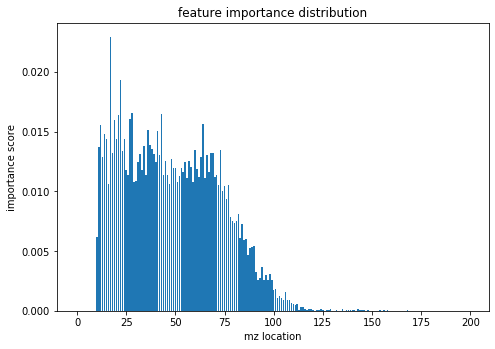

In [12]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(feature_scores.index,feature_scores)
plt.ylabel('importance score')
plt.xlabel('mz location')
plt.title('feature importance distribution')
plt.show()

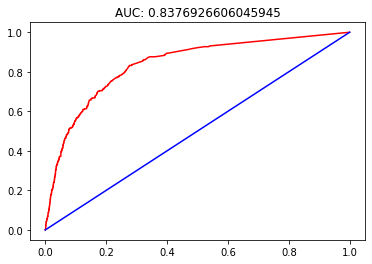

In [13]:
fpr, tpr, thresholds = roc_curve(y_test, clf_opt.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr,'r')
plt.plot([0,1],[0,1],'b')
plt.title('AUC: {}'.format(auc(fpr,tpr)))
plt.show()